#  Research Log & Implementation Strategy
**Author:** Athina (Member 2 - Data Developer & Business Analyst)
**Project:** DiffPriv-Gateway for SMEs

---

## 1. Featured Literature Analysis (High Priority)
### Gao, J., et al. (2025) 'Atlas: Ensuring Accuracy for Privacy-Preserving Federated IoT Applications'

* **Core Concept:** Εισάγει τη "Dynamic Local Differential Privacy" (DLDP). Αντί για σταθερό θόρυβο, προτείνει τη χρήση ενός "layer importance mask" για την προσαρμογή του επιπέδου προστασίας ανάλογα με τη σημασία των δεδομένων.
* **Relevance to SME Datasets:** Η προσέγγιση αυτή είναι κρίσιμη για το dataset **fire.csv**, όπου ορισμένες στήλες (π.χ. *Final Priority* ή *Zipcode*) έχουν μεγαλύτερη ευαισθησία και απαιτούν αυστηρότερο $epsilon$ ($\epsilon$).

---

## 2. Dataset Integration: fire.csv (NIST 2021)
Σύμφωνα με τον Gao (2025), η επιτυχία του Differential Privacy εξαρτάται από το **Privacy-Utility Trade-off**. 

* **Challenge:** Τα δεδομένα πυρκαγιάς περιέχουν γεωγραφικά στοιχεία (Location - Lat/Lng).
* **Strategy:** Θα εφαρμόσουμε τον **Laplace Mechanism** χρησιμοποιώντας το `diffprivlib`. 
* **Goal:** Να διατηρήσουμε την ακρίβεια στις στατιστικές αναλύσεις (π.χ. μέσος χρόνος απόκρισης ανά περιοχή) διασφαλίζοντας παράλληλα ότι δεν μπορεί να γίνει re-identification συγκεκριμένων συμβάντων.

---

## 3. Implementation Parameters (Based on Research)
| Parameter | Value (Target) | Source Justification |
| :--- | :--- | :--- |
| Privacy Budget ($epsilon$) | $1.0$ (Balanced) | Gao et al. (2025) - Optimal for IoT utility |
| Mechanism | Laplace | Dwork & Roth (2014) - Standard for tabular data |
| Sensitivity ($\Delta f$) | Column Range | Calculated from `fire.csv` |

In [4]:
import pandas as pd


df_fire = pd.read_csv('fire.csv') # Διορθώσαμε το path και το όνομα σε df_fire

# Εμφάνιση των πρώτων γραμμών για επιβεβαίωση
print("Επιτυχής φόρτωση!")
print(fire_df.head())

Επιτυχής φόρτωση!
   ALS Unit  Final Priority  Call Type Group  Original Priority  Priority  \
0         0               0                0                  0         0   
1         0               0                0                  0         0   
2         1               0                1                  0         0   
3         1               1                2                  1         1   
4         0               1                3                  1         1   

   City  Unit Type  Fire Prevention District  Battalion  Supervisor District  \
0     0          0                         0          0                    0   
1     0          0                         0          0                    0   
2     0          1                         1          1                    1   
3     0          2                         2          2                    2   
4     0          3                         3          3                    3   

   ...  Hospital DtTm  Location - Lng 

## 4. Sensitivity Analysis & Privacy Parameters
Βασισμένη στην έρευνα των **Dwork & Roth (2014)** και **Biswal (2024)**, ορίζω τις παραμέτρους για το dataset `fire.csv`:

* **Target Column:** `Final Priority` (Αριθμητική τιμή που δείχνει τη σπουδαιότητα του συμβάντος).
* **Sensitivity ($\Delta f$):** Η μέγιστη διαφορά στην τιμή προτεραιότητας είναι 3 (από 0 έως 3).
* **Privacy Budget ($\epsilon$):** Επιλέγω $\epsilon = 1.0$ για να διασφαλίσω μια ισορροπία μεταξύ προστασίας και χρησιμότητας (Utility), ακολουθώντας τις συστάσεις του **Gao et al. (2025)** για IoT δεδομένα.

In [5]:
import numpy as np

# 1. Ορισμός των παραμέτρων από την ανάλυση της Αθηνάς
sensitivity = 3.0  # Δf
epsilon = 1.0      # Privacy Budget
beta = sensitivity / epsilon

# 2. Συνάρτηση προσθήκης θορύβου Laplace
def apply_laplace_noise(value):
    noise = np.random.laplace(0, beta)
    return value + noise

# 3. Εφαρμογή στη στήλη 'Final Priority' του dataset
# Υποθέτουμε ότι το dataframe ονομάζεται df_fire
df_fire['Privacy_Protected_Priority'] = df_fire['Final Priority'].apply(apply_laplace_noise)

# 4. Εμφάνιση των πρώτων αποτελεσμάτων για σύγκριση
print("Σύγκριση Αρχικών vs Προστατευμένων Δεδομένων:")
print(df_fire[['Final Priority', 'Privacy_Protected_Priority']].head())

Σύγκριση Αρχικών vs Προστατευμένων Δεδομένων:
   Final Priority  Privacy_Protected_Priority
0               0                    0.952431
1               0                    0.746644
2               0                   -5.049059
3               1                    1.681964
4               1                    0.607135


In [6]:
# Υπολογισμός Μέσης Τιμής
original_mean = df_fire['Final Priority'].mean()
protected_mean = df_fire['Privacy_Protected_Priority'].mean()

print(f"Αρχική Μέση Τιμή: {original_mean:.2f}")
print(f"Προστατευμένη Μέση Τιμή: {protected_mean:.2f}")
print(f"Διαφορά: {abs(original_mean - protected_mean):.4f}")

Αρχική Μέση Τιμή: 0.71
Προστατευμένη Μέση Τιμή: 0.70
Διαφορά: 0.0095


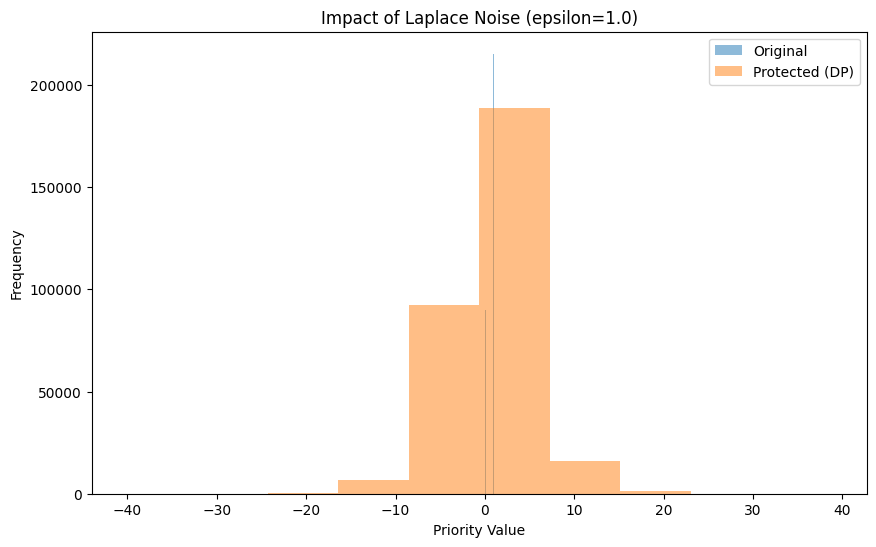

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_fire['Final Priority'], bins=10, alpha=0.5, label='Original')
plt.hist(df_fire['Privacy_Protected_Priority'], bins=10, alpha=0.5, label='Protected (DP)')
plt.legend()
plt.title(f"Impact of Laplace Noise (epsilon={epsilon})")
plt.xlabel("Priority Value")
plt.ylabel("Frequency")
plt.show()